### A Naive XGBoost Model to Find Feature Importance

---

* Objective: 
  * Use XGBoost To find what features are important.
  * Start to do light feature engineering, certainly more work here.
  * Start to build helper functions
* Issues: How to train test split? By date?

__author__: Eric Fitchwell
__status__: Development

In [1]:
#packages

import pandas as pd
from xgboost.sklearn import XGBRegressor
from sklearn import preprocessing
import seaborn as sns
import warnings

# hide warnings
warnings.filterwarnings('ignore')

In [2]:
def read_data(path):
    """
    read in data to xgboost on!
    
    """

    df = pd.read_csv(path)

    df['alarm_format'] = pd.to_datetime(df['alarm_dttm'])

    df['arrival_format'] = pd.to_datetime(df['arrival_dttm'])

    df['arrival_time'] = (df['arrival_format'] - df['alarm_format'])
    
    df['minutes'] = (df.arrival_time.dt.seconds) / 60
    
    df['day_of_week'] = df['alarm_format'].dt.day_name().astype(str)
    
    df['dayflag'] = (df.alarm_format.dt.hour > 5) & (df.alarm_format.dt.hour <18)
    
    cols = ['minutes','alarm_format','arrival_format','day_of_week','dayflag','zipcode',\
            'battalion', 'station_area', 'ems_units', 'number_of_alarms', 'primary_situation',\
            'action_taken_primary', 'property_use', 'neighborhood_district', 'supervisor_district', 'structure_type',\
            'area_of_fire_origin','detector_type','detector_operation']
    
    return df[cols]

In [3]:
path = '/Users/ericfitchwell/Documents/Grad School/2020_fires.csv'

df = read_data(path)


In [4]:
def split_data(df,months_excluded=3):
    """
    split data based on dates... needs improvement but getting going
    change number of months to holdout
    """
    X = df.loc[:,df.columns != 'minutes']
    y = df['minutes']
    
    date_max = max(df['alarm_format'])
    
    train_date_max = date_max - pd.DateOffset(months=months_excluded)

    
    X_train, y_train = X[X.alarm_format <= train_date_max], y[X.alarm_format <= train_date_max]
    X_test, y_test = X[X.alarm_format > train_date_max] , y[X.alarm_format > train_date_max]
    
    X_train.drop(['arrival_format','alarm_format'],axis=1,inplace=True)
    X_test.drop(['arrival_format','alarm_format'],axis=1,inplace=True)
    
    ############################### needs encoded
    lbl = preprocessing.LabelEncoder()
    
    X_train['day_of_week'] = lbl.fit_transform(X_train['day_of_week'].astype(str))
    X_train['battalion'] = lbl.fit_transform(X_train['battalion'].astype(str))
    X_train['primary_situation'] = lbl.fit_transform(X_train['primary_situation'].astype(str))
    X_train['action_taken_primary'] = lbl.fit_transform(X_train['action_taken_primary'].astype(str))
    X_train['property_use'] = lbl.fit_transform(X_train['property_use'].astype(str))
    X_train['neighborhood_district'] = lbl.fit_transform(X_train['neighborhood_district'].astype(str))
    X_train['structure_type'] = lbl.fit_transform(X_train['structure_type'].astype(str))
    X_train['area_of_fire_origin'] = lbl.fit_transform(X_train['area_of_fire_origin'].astype(str))
    X_train['detector_type'] = lbl.fit_transform(X_train['detector_type'].astype(str))
    X_train['detector_operation'] = lbl.fit_transform(X_train['detector_operation'].astype(str))
    
    X_test['day_of_week'] = lbl.fit_transform(X_test['day_of_week'].astype(str))
    X_test['battalion'] = lbl.fit_transform(X_test['battalion'].astype(str))
    X_test['primary_situation'] = lbl.fit_transform(X_test['primary_situation'].astype(str))
    X_test['action_taken_primary'] = lbl.fit_transform(X_test['action_taken_primary'].astype(str))
    X_test['property_use'] = lbl.fit_transform(X_test['property_use'].astype(str))
    X_test['neighborhood_district'] = lbl.fit_transform(X_test['neighborhood_district'].astype(str))
    X_test['structure_type'] = lbl.fit_transform(X_test['structure_type'].astype(str))
    X_test['area_of_fire_origin'] = lbl.fit_transform(X_test['area_of_fire_origin'].astype(str))
    X_test['detector_type'] = lbl.fit_transform(X_test['detector_type'].astype(str))
    X_test['detector_operation'] = lbl.fit_transform(X_test['detector_operation'].astype(str))
    ###############################
    
    return X_train, y_train, X_test, y_test

### XGBoost Feature Measurements


* ‘weight’ - the number of times a feature is used to split the data across all trees.
* ‘gain’ - the average gain across all splits the feature is used in.
* ‘cover’ - the average coverage across all splits the feature is used in.
* ‘total_gain’ - the total gain across all splits the feature is used in.
* ‘total_cover’ - the total coverage across all splits the feature is used in.


[XGBoost Docs](https://xgboost.readthedocs.io/en/latest/python/python_api.html#module-xgboost.sklearn)

In [5]:
def run_model(df):
    
    X_train, y_train, X_test, y_test = split_data(df)
    
    model = XGBRegressor(max_depth=3,
                     n_estimators=100,
                     min_child_weight=2,
                     learning_rate=.2)
    
    
    model.fit(X_train,y_train,verbose=False)
    
    
    y_pred = model.predict(X_test)

    df_out = pd.DataFrame()

    df_out['preds'] = y_pred
    
    return df_out, model

In [6]:
df1, res = run_model(df)

In [7]:
def show_importance(model,metric='weight'):
    """
    
    show feature importance by metric interested in, see xgboost docs for more
    
    """
    feature_important = model.get_booster().get_score(importance_type=metric)
    keys = list(feature_important.keys())
    values = list(feature_important.values())

    data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
    
    return data.plot(kind='barh')

<AxesSubplot:>

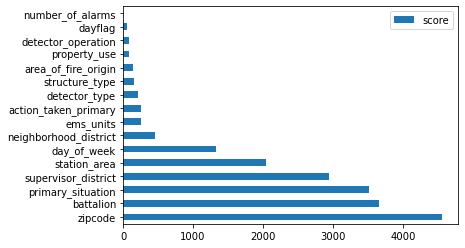

In [8]:
show_importance(res,'gain')

## EDA On Response to Prep for Outlier Model

---

* See if distance matters on outlier responses

In [9]:
df['minutes'].describe()

count    46519.000000
mean         4.476618
std          2.661556
min          0.000000
25%          3.166667
50%          4.050000
75%          5.183333
max        104.533333
Name: minutes, dtype: float64

[Text(0.5, 1.0, 'Fire Response Time')]

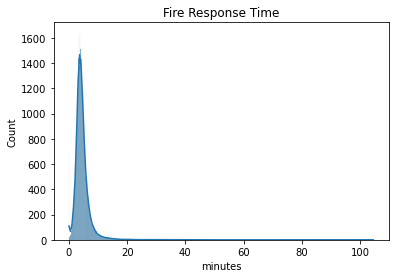

In [10]:
sns.histplot(data=df,x='minutes',kde=True).set(title='Fire Response Time')

In [11]:
def find_percentiles(df):
    """
    adds a column with the percentiles for column declared and returns outlier records
    
    outliers defined as > 90th percentile
    
    """
    
    df['per'] = df.minutes.rank(pct = True)
    
    df1 = df.query('per > .9')
    
    df1.drop(['per'],axis=1,inplace=True)
    
    return df1

In [12]:
df2 = find_percentiles(df)

[Text(0.5, 1.0, 'Fire Response Time 90th Percentiles')]

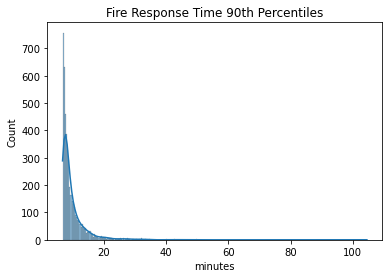

In [14]:
sns.histplot(data=df2
            ,x='minutes',kde=True).set(title='Fire Response Time 90th Percentiles')

In [15]:
df3, res2 = run_model(df2)

<AxesSubplot:>

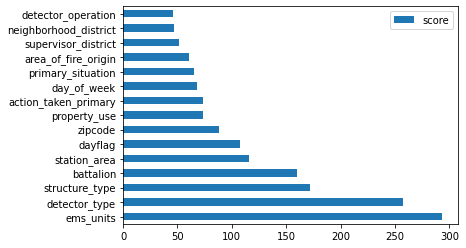

In [18]:
show_importance(res2,'gain')